In [1]:
import numpy as np
from pprint import pprint

import qcodes as qc
from qcodes import MultiParameter, Measurement, Parameter, MultiParameterWithSetpoints, Instrument
from qcodes.instrument.parameter import expand_setpoints_helper
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Sequence, Arrays


class MockMultiParamWithSetpoints(MultiParameterWithSetpoints):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.i = 0
        
    def get_raw(self):
        npts = self.root_instrument.npts()
        val = (np.arange(npts) + self.i*npts*10,)*2
        self.i +=1
        return val
    
    
class TimeAxis(Parameter):
    def get_raw(self):
        npts = self.root_instrument.npts()
        return np.arange(npts)
    
    
class MockDAQ(Instrument):    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
        
        self.add_parameter(name='npts',
                           initial_value=10,
                           label='Number of points',
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter(name='time_axis',
                           label='Time',
                           unit='s',
                           vals=Arrays(shape=(self.npts,)),
                           parameter_class=TimeAxis)
        
        self.add_parameter(name='traces',
                           names=('A','B'),
                           units=('V','V'),
                           vals=Sequence(elt_validator=Arrays(shape=(self.npts,)), length=2),
                           setpoints=(self.time_axis,),
                           parameter_class=MockMultiParamWithSetpoints)

daq = MockDAQ('daq')
ext_param = Parameter('ext', set_cmd=None, get_cmd=None)

In [2]:
qc.new_experiment(name='multiparam_w_sp_test', sample_name='none')

meas = Measurement()
meas.register_parameter(ext_param)
meas.register_parameter(daq.traces, setpoints=(ext_param,))

In [3]:
with meas.run() as datasaver:  
    daq.npts(10)
    for ext in range(3):
        datasaver.add_result((ext_param, ext), *expand_setpoints_helper(daq.traces))
        run_id = datasaver.run_id

Starting experimental run with id: 152


In [4]:
ds = load_by_id(run_id)
        
pprint(ds.get_data('ext','A','B'))
pprint(ds.get_parameter_data('A','B'))

[[0, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), None],
 [0, None, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 [1, array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109]), None],
 [1, None, array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109])],
 [2, array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209]), None],
 [2, None, array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209])]]
{'A': {'A': array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
       [200, 201, 202, 203, 204, 205, 206, 207, 208, 209]]),
       'daq_time_axis': array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
       'ext': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])},
 'B': {'B': array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [100, 101, 102, 103, 104, 105, 106, 10

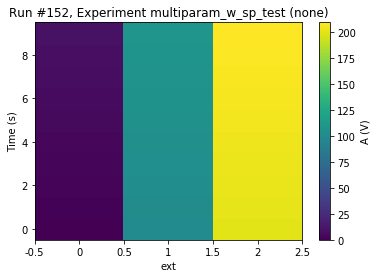

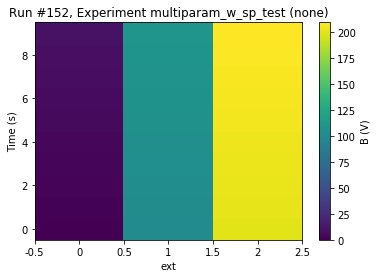

In [5]:
_ = plot_by_id(run_id)